# Optimization

In this notebook, we demonstrate the discussion in section TODO.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# For reproducibility
tf.random.set_seed(42)
tf.config.experimental.enable_op_determinism()

## Data and Model for Demostration

Load and process MNIST dataset.

In [2]:
# Preprocess MNIST
mnist = tf.keras.datasets.mnist
(x_train, y_train), _ = mnist.load_data()
x_train = x_train.astype('float32')
x_train = x_train.reshape([-1, 28, 28, 1])  # add channel.
x_train = x_train / 255.0
y_train = y_train.astype('int32')

# Convert to dataset
ds_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
ds_train = ds_train.batch(64)

In [3]:
def build_model(model_type):
    if model_type == 0:
        model = tf.keras.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, 'relu'),
            tf.keras.layers.Dense(64, 'relu'),
            tf.keras.layers.Dense(32, 'relu'),
            tf.keras.layers.Dense(10),
        ])
    elif model_type == 1:
        model = tf.keras.Sequential([
            tf.keras.layers.Conv2D(32, 3),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Conv2D(64, 3),
            tf.keras.layers.ReLU(),
            tf.keras.layers.MaxPool2D((2, 2)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, 'relu'),
            tf.keras.layers.Dense(10),
        ])
    else:
        raise ValueError()

    # Build the model
    x_batch = tf.random.uniform([128, 28, 28, 1])
    _ = model(x_batch)

    return model


def get_num_params(model):
    num_params = 0
    for v in init_model.variables:
        num_params += tf.reduce_prod(tf.shape(v)).numpy()
    return num_params


init_model = build_model(1)
print(f'Number of parameters = {get_num_params(init_model)}')

Number of parameters = 1199882


Then define loss and training functions.

In [4]:
def cross_entropy_loss(logits, labels):
    """Compute cross entropy loss with a sparse operation."""
    sparse_ce = tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits, labels=labels)
    return tf.reduce_mean(sparse_ce)


def train_step(model, optimizer, x_batch, y_batch):
    with tf.GradientTape() as tape:
        y_pred = model(x_batch)
        loss_batch = cross_entropy_loss(y_pred, y_batch)
    grads = tape.gradient(loss_batch, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))
    return loss_batch

Function for demostration.

In [5]:
def clone_model(model):
    new_model = tf.keras.models.clone_model(model)
    for i, var in enumerate(model.variables):
        new_model.variables[i].assign(var)
    return new_model


def demostrate_optimizer(optimizer, epochs=5):
    model = clone_model(init_model)
    loss_values = []

    # Training process.
    for epoch in range(epochs):
        ds_iter = ds_train.as_numpy_iterator()
        while True:
            try:
                x_batch, y_batch = next(ds_iter)
            except StopIteration:
                break
            loss_batch = train_step(model, optimizer, x_batch, y_batch)
            loss_values.append(loss_batch.numpy())
            if np.isnan(loss_values[-1]):
                raise ValueError('NaN')
        print(f'epoch = {epoch}, loss = {np.mean(loss_values[-200:])}')

    print(f'Final loss = {np.mean(loss_values[-200:])}')
    plt.plot(loss_values)
    plt.title('Training loss.')
    plt.show()
    return loss_values, model, optimizer

We use Adam optimizer as baseline.

epoch = 0, loss = 0.06079322472214699
epoch = 1, loss = 0.03295600041747093
epoch = 2, loss = 0.02186666801571846
epoch = 3, loss = 0.01400552038103342
epoch = 4, loss = 0.012738760560750961
Final loss = 0.012738760560750961


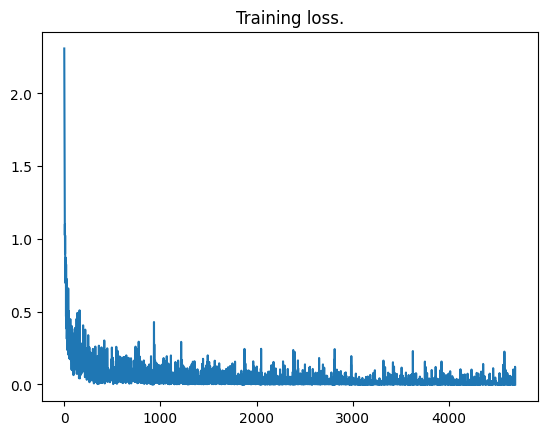

In [6]:
base_loss_values, base_model, base_optimizer = \
    demostrate_optimizer(tf.keras.optimizers.Adam())

Then, implemented the optimizer shown as a simple instance in section TODO.

In [7]:
class SelfAdaptiveOptimizer(tf.Module):

    def __init__(self, learning_rate=1e-4, decay_factor=0.95):
        self.learning_rate = learning_rate
        self.decay_factor = decay_factor
        self.smeared_grads = []
        self.built = False

    def apply_gradients(self, grads_and_vars):
        grads_and_vars = list(grads_and_vars)
        if not self.built:
            for _, var in grads_and_vars:
                self.smeared_grads.append(tf.Variable(tf.zeros(shape=var.shape)))
            self.built = True
        # Perform Adam updates
        for i, (grad, var) in enumerate(grads_and_vars):
            smeared_grad = self.smeared_grads[i]
            smeared_grad.assign(
                self.decay_factor * smeared_grad
                + (1-self.decay_factor) * grad
            )
            var.assign_sub(self.learning_rate*(tf.math.sign(smeared_grad)))

epoch = 0, loss = 0.06087633967399597
epoch = 1, loss = 0.03272664174437523
epoch = 2, loss = 0.019912539049983025
epoch = 3, loss = 0.013656491413712502
epoch = 4, loss = 0.009854553267359734
Final loss = 0.009854553267359734


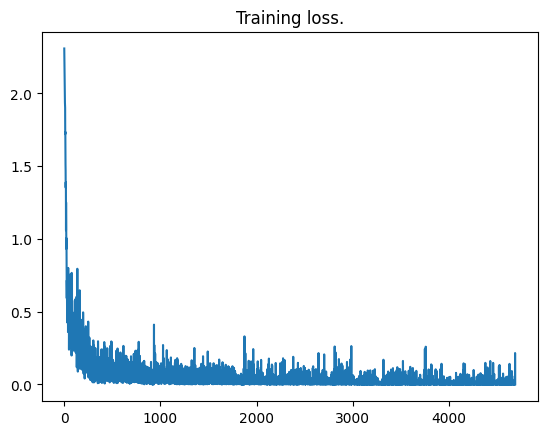

In [8]:
loss_values, model, optimizer = \
    demostrate_optimizer(SelfAdaptiveOptimizer(learning_rate=2e-4))

## Conclusion

We find that the optimizer shown as a simple instance in the section just a little slower than the Adam optimizer. But the RAM occupition is half comparing with the later.